In [3]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import scipy
import pickle as pkl
import os

from utils.points import generate_points, generate_points_random, jitter_image_points
from utils.homography import get_homography, apply_homography
from utils.plotting import points_to_image, plot_points_as_image, plot_multiple_images
from utils.camera import build_camera_matrix, get_rotated_camera
from utils.calibration import calibrate

In [4]:
# set up original camera matrix
f = 300
u = f // 2
v = f / 2

P, K, C = build_camera_matrix(f, f, u, v, 0, np.array([0, 0, 0, 1]))
P

array([[300.,   0., 150.,   0.],
       [  0., 300., 150.,   0.],
       [  0.,   0.,   1.,   0.]])

In [5]:
P_30z = get_rotated_camera(K, C, z=np.pi/6)
P_15x = get_rotated_camera(K, C, x=np.pi/12)

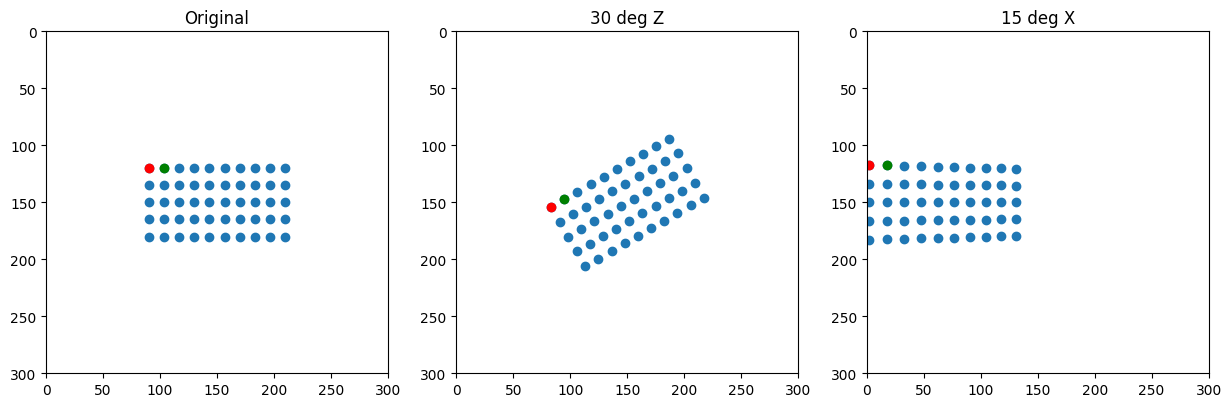

In [6]:
# when working with creating the image, we need to flip the y axis, and make sure that the axis order is correct (ij does top-down, left-right)
points_3dh = generate_points(5, 10)
# points_3dh = generate_points_random(15)
points_2dh_orig = points_3dh @ P.T
points_2d_orig = points_2dh_orig[:, :2] / points_2dh_orig[:, 2].reshape(-1, 1)

points_2dh_30z = points_3dh @ P_30z.T
points_2d_30z = points_2dh_30z[:, :2] / points_2dh_30z[:, 2].reshape(-1, 1)

points_2dh_15x = points_3dh @ P_15x.T
points_2d_15x = points_2dh_15x[:, :2] / points_2dh_15x[:, 2].reshape(-1, 1)

# apply gaussian noise
# points_2d_orig = jitter_image_points(points_2d_orig, sigma=1)
# points_2d_30z = jitter_image_points(points_2d_30z, sigma=1)
# points_2d_15x = jitter_image_points(points_2d_15x, sigma=1)

plot_points_as_image(points_2d_orig, points_2d_30z, points_2d_15x, titles=['Original', '30 deg Z', '15 deg X'])

In [7]:
if not os.path.exists('data'):
    os.makedirs('data')

if not os.path.exists('data/image_orig.pkl'):
    image_orig = points_to_image(points_2d_orig)
    with open('data/image_orig.pkl', 'wb') as f:
        pkl.dump(image_orig, f)
else:
    with open('data/image_orig.pkl', 'rb') as f:
        image_orig = pkl.load(f)

if not os.path.exists('data/image_30z.pkl'):
    image_30z = points_to_image(points_2d_30z)
    with open('data/image_30z.pkl', 'wb') as f:
        pkl.dump(image_30z, f)
else:
    with open('data/image_30z.pkl', 'rb') as f:
        image_30z = pkl.load(f)

if not os.path.exists('data/image_15x.pkl'):
    image_15x = points_to_image(points_2d_15x)
    with open('data/image_15x.pkl', 'wb') as f:
        pkl.dump(image_15x, f)
else:
    with open('data/image_15x.pkl', 'rb') as f:
        image_15x = pkl.load(f)

H_30z = get_homography(points_2d_30z, points_2d_orig, normalize=True)
H_15x = get_homography(points_2d_15x, points_2d_orig, normalize=True)
rectified_image_30z = apply_homography(image_30z, H_30z, (0, 0, 300, 300))
rectified_image_15x = apply_homography(image_15x, H_15x, (0, 0, 300, 300))

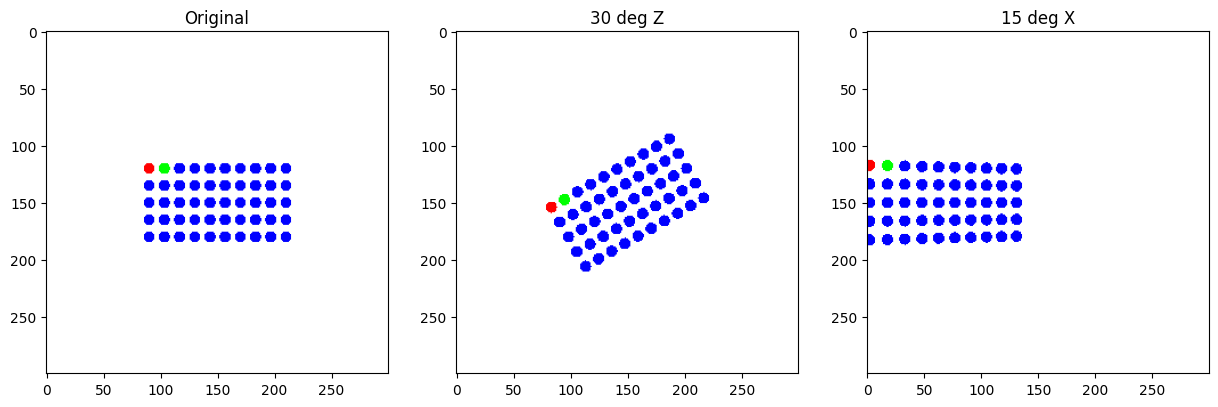

In [8]:
plot_multiple_images(image_orig, image_30z, image_15x, titles=['Original', '30 deg Z', '15 deg X'])

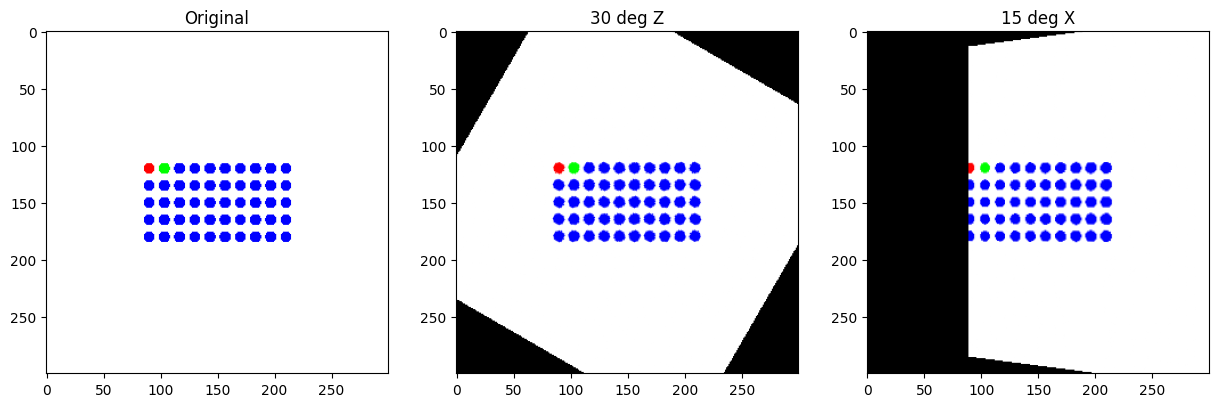

In [9]:
plot_multiple_images(image_orig, rectified_image_30z, rectified_image_15x, titles=['Original', '30 deg Z', '15 deg X'])

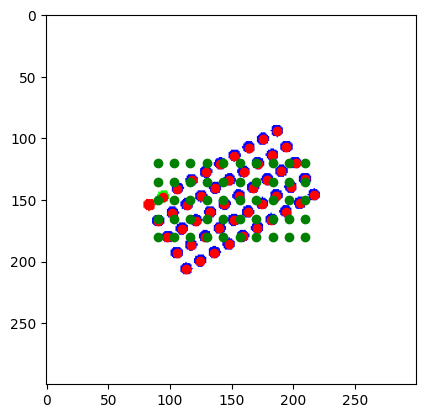

In [10]:
plt.imshow(image_30z)
plt.scatter(points_2d_30z[:, 1], points_2d_30z[:, 0], c='r')

rectified_points = np.hstack([points_2d_30z, np.ones((points_2d_30z.shape[0], 1))]) @ H_30z.T
rectified_points = rectified_points[:, :2] / rectified_points[:, 2].reshape(-1, 1)
plt.scatter(rectified_points[:, 1], rectified_points[:, 0], c='g')

In [11]:
calibrate(points_2d_orig, points_2d_30z, points_2d_15x)

array([[ 3.00000000e+02, -1.30229161e-11,  1.50000000e+02],
       [-4.09310189e-14,  3.00000000e+02,  1.50000000e+02],
       [-0.00000000e+00, -0.00000000e+00,  1.00000000e+00]])